---
layout: single
title: "[C03 분류]02 이진분류기 성능측정 방법"
categories: ml
tag: [python, ml]
toc: true
author_profile: false
typora-root-url: ../
sidebar:
  nav: "counts"
---


### train test set 준비

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5) # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

### 훈련

In [3]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## 교차 검증을 통한 정확도 측정

In [4]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### 교차 검증 정확도 측정의 문제점
- 확실하게 5인 것 빼고 나머지를 다 5가 아니라고 해도 90% 이상의 정확도를 얻기 매우 쉽다
- 예를 들어 모두 '5가 아니다' 라고 답하는 모델의 정확도도 90%가 나올 것이다.

### 시사점
- 분류기에서 정확도로 성능을 측정하는 것은 큰 의미가 없는 경우가 많다
- 불균형한(특정 클래스가 다른 것보다 월등히 많은 경우) 데이터셋을 다룰 때 특히 그렇다.

## 더 나은 방법: Confusion Matrix(오차 행렬)
- 다음 네 가지로 분류하는 것이다
- 뒷글자는 뭐라고 예측했는지 (Positive vs Negative)
- 앞글자는 그 예측이 맞았는지 (True vs False)

1. TP: 긍정예측이 사실이었을 경우(사실:긍정) (True Positive)
2. FP: 부정예측이 틀렸을 경우(사실:부정) (False Positive)
3. TN: 긍정예측이 사실이었을 경우(사실:부정) (True Negative)
4. FN: 부정예측이 틀렸을 경우(사실:긍정) (False Negative)

In [5]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

#### confusion matrix 해석
- 열(가로, column)은 예측값: Negative, Positive
- 행(세로, row)은 실제값: Negative, Positive

- (0,0)은(왼쪽위 ) Negative를 Negative로 예측했으므로 True Negative
- (0,1)은(왼쪽아래) Positive를 Negative로 예측했으므로 False Negative
- (1,0)은(오른위 ) Negative를 Positive로 예측했으므로 False Positive
- (1,1)은(오른아래) Positive를 Positive로 예측했으므로 True Positive

## 정밀도와 재현율
### 정밀도(precision)
- 양성 예측의 정확도
- Positive로 예측한 것이 맞았을 확률
- TP / (TP + FP)

### 재현율(recall)
- 민감도(sensitivity) 또는 진짜 양성 비율(true positive rate)라고도 함
- 실제 Positive인 것 중 얼마나 많이 Positive로 예측했나
- TP / (FN + TP)

### 정밀도와 재현율을 같이 봐야 하는 이유
- 숫자 5가 2000개, 5가 아닌것이 8000개 있다고 가정
- 확실한 하나만 5라고 예측하고 나머지는 다 5가 아니라고 예측한 경우
- 정밀도는 1/1로 100%가 됨
- 재현율을 보면, 1/2000으로 매우 낮음
- 즉, 확실하지 않아도 과감하게 Positive로 예측하면 정밀도는 낮아지지만 재현율은 높아짐
- 정말 확실한 것만 Positive로 예측하면 정밀도는 높아지지만 재현율은 낮아짐

In [6]:
from sklearn.metrics import precision_score, recall_score
print('precision_score:', precision_score(y_train_5, y_train_pred))
print('recall_score:', recall_score(y_train_5, y_train_pred))

precision_score: 0.8370879772350012
recall_score: 0.6511713705958311


- 5라고 답한 것 중에서 83.7%가 실제 5였다
- 전체 숫자 5 중에서 2/3만 5라고 답했다

(암 진단이었다면)
- 암이라고 판단한 환자 중 83.7%가 실제 암이었다
- 전체 암환자 중 2/3만 암이라고 진단했다 > 1/3 환자는 암이 아니라고 진단해 치료 기회를 놓쳤다!

## F1 Score
- 정밀도와 재현율의 조화 평균
- 둘 다 점수가 높아야 높게 나옴
- 하나는 높고 하나는 중간정도라면 점수가 확 떨어짐

### F1이 항상 옳은가?
- 예를 들어 어린아이에게 안전한 영상을 걸러낸다면
- 좋은 동영상은 다 잡아내지만 때때로 나쁜 영상이 노출되는 것(높은 재현율, 조금 떨어지는 정밀도)보다
- 좋은 동영상을 더 많이 놓치더라도 나쁜 영상을 확실히 거르는 것(낮은 재현율, 높은 정밀도)가 더 나을 것
- 위는 '좋은 동영상'을 Positive로 봤을 경우임

In [7]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 정밀도 vs 재현율: Threshold(임계값)
- 분류기는 결정 함수(decition function)를 사용하여 각 샘플의 점수를 계산한다
- 예를 들어 5인지 판별하는 분류기는, 이 이미지가 몇 점 정도로 5라고 예측되는지를 계산하는 결정 함수를 돌리는 것이다
- 임계값은 점수가 얼마를 넘어야 Positive로 판별할지를 정해주는 값이다.
- 예를 들어 일반적으로 점수가 100~300인데 임계값이 290이라면 아주아주 확실한 것만 Positive로 판별할 것이다.
- 따라서 임계값이 높아지면 일반적으로 재현율은 낮아지고 정밀도는 높아진다
- 이 트레이드오프를 곡선으로 그려 최적점을 결정(개발자의 선택이다)할 수 있다

### 임계값을 직접 정하기
- 임계값을 직접 정하는 것은 불가능
- decision_function() 메서드를 호출해 각 샘플의 '점수'를 얻을 수 있는데
- 이를 이용해 직접 예측을 만들면 됨

In [8]:
y_some_scores = sgd_clf.decision_function(X[:12])
print('scores:', y_some_scores)

threshold = 3000
y_some_pred = (y_some_scores > threshold)
print('pred:', y_some_pred)

scores: [  2164.22030239  -5897.37359354 -13489.14805779  -4623.84515943
  -6873.05248453  -3908.27576291  -4851.9422397   -4988.52407755
  -2226.78132866  -4081.33692831  -5711.47789687   4742.52813158]
pred: [False False False False False False False False False False False  True]


- 원래라먼 첫번째도 양수이므로 True로 예측했어야 했다.
- 임의로 임계값을 3000으로 정했기 때문에 False로 판별했다
- 사실은 True가 맞기 때문에 놓친 것, 즉 재현율이 줄어든 것이다

### 정밀도와 재현율을 시각화해 적절한 임계값 정하기
1. cross_val_predict() 함수를 통해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
2. 예측 결과가 아니라 결정 점수를 반환받도록 method='decision_function' 파라미터를 지정해야 한다.
3. precision_recall_curve() 함수를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산 가능하다
4. 계산된 결과를 matplotlib을 통해 그린다

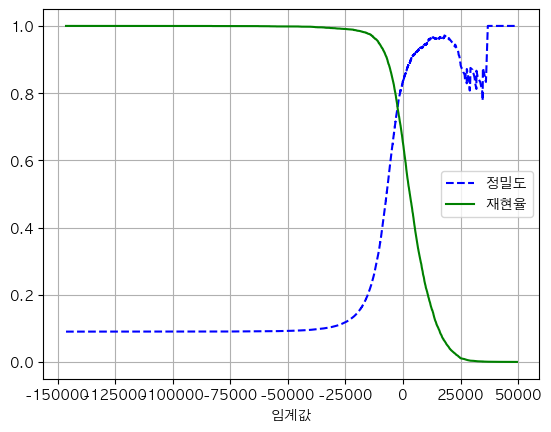

In [9]:
# 적절한 임계값을 정하기 위해 훈련 세트에 있는 모든 샘플의 점수를 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# 모든 임계값에 대해 정밀도와 재현율을 계산
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# 임계값에 대한 정밀도와 재현율 그래프 그리기
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
    plt.legend()
    plt.grid()
    plt.xlabel('임계값')
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### 임계값이 오를 때 정밀도는 낮아질 수 있다
- 임계값을 올릴 때 재현율은 절대 낮아질 수 없지만 정밀도는 낮아질 수 있음
- 예를 들어 임계값이 높아져 Positive 예측의 전체 갯수 자체가 5개에서 4개로 줄어든다면
- 4/5 (80%)에서 3/4(75%)로 정밀도가 떨어짐

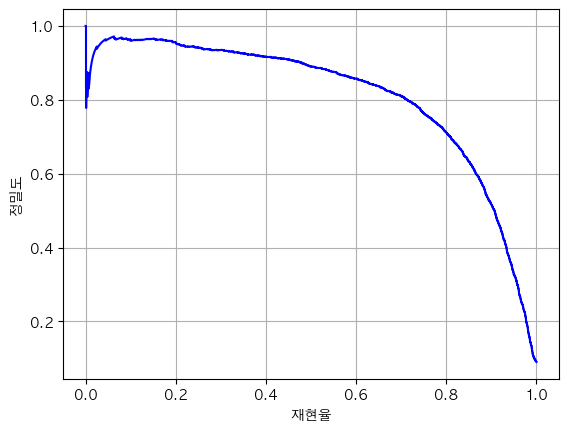

In [10]:
# 재현율에 대한 정밀도 곡선 그리기
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-')
    plt.xlabel('재현율')
    plt.ylabel('정밀도')
    plt.grid()
    plt.show()

plot_precision_vs_recall(precisions, recalls)

## 프로젝트 목표에 따른 임계값 설정하기
- 정밀도 90%가 목표라면
- 정밀도 90%를 달성하는 가장 낮은 임계값을 아래와 같이 사용할 수 있음

In [11]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # 90% 정밀도를 달성하는 가장 낮은 임계값

y_train_pred_90 = (y_scores >= threshold_90_precision) # 임계값보다 크거나 같은 점수를 갖는 샘플들을 True로 반환

print('정밀도:', precision_score(y_train_5, y_train_pred_90))
print('재현율:', recall_score(y_train_5, y_train_pred_90))

정밀도: 0.9000345901072293
재현율: 0.4799852425751706


이것이 안전한 영상을 찾아내는 분류기였다면, 안전한 영상의 절반 이상을 포기하는 대신 나쁜 영상 비율을 10% 미만으로 유지하는 것

## ROC (Receiver Operating Characteristic) 곡선
- "최대한 좋은 영상을 안 버리고 싶다"(재현율을 높이고 싶다) 가 목표일 때
- 그러면 원래 나쁜 영상(Negative)인데 좋은 영상(Positive)으로 잘못 분류되는 비율이 얼마나 늘어나는지를 보는 곡선
- 거짓 양성 비율(FPR) 대비 진짜 양성 비율(TPR = 재현율)을 보는 곡선
- FPR은 N을 P로 분류한 비율이기 때문에, 1 - TNR(N을 N으로 분류한 비율)과 일치함
- TNR을 특이도(specificity)라고 함
- 즉 ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프

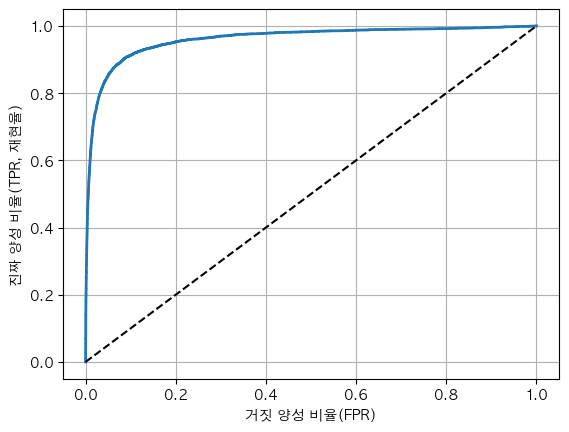

In [16]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # 대각 점선
    plt.xlabel('거짓 양성 비율(FPR)')
    plt.ylabel('진짜 양성 비율(TPR, 재현율)')
    plt.grid()

plot_roc_curve(fpr, tpr)

#### 대략적인 해석
- 재현율을 0.9 이상 높이기 시작하면 FPR이 가파르게 증가한다

## ROC vs 정밀도/재현율 곡선, 어느 것을 보나요?
- 양성(Positive)이 드물거나, 거짓 음성보다 거짓 양성이 중요할 때 PR 곡선을 사용
- 그 반대는 ROC를 사용
- 예를 들어 이 분류기는 ROC 곡선이 아주 훌륭하게 나옴(FPR을 낮게 유지하고도 TPR을 끌어올릴 수 있음)
- 그런데 이것은 Positive(is 5?)가 드물기 때문
- 이런 경우에는 정밀도/재현율 곡선을 확인하는 것이 의사결정에 훨씬 도움이 됨
- 최대한 나쁜 영상을 확실하게 제거하고 싶다 = False Positive를 낮게 컨트롤하고싶다 = 정밀도/재현율 곡선
- 최대한 좋은 영상을 많이 확보하고 싶다 = False Negative를 낮게 컨트롤하고 싶다(=True Positive를 높게 컨트롤하고 싶다) = ROC곡선

- '시리야' 라고 부르는 것에 대답하는 음성 인식기를 만든다
- '시리야' 라고 부르는 것을 Positive로 놓고 이진분류하는 판별기를 만든다
- 시리라고 불렀을때 종종 대답 안하더라도, '싫어' 등 다른 말을 했을때 잘못 반응하는 경우를 줄이고 싶다 = False Positive를 줄이고 싶다(시리야가 아닌데 시리야로 판별하는 경우 줄이기)
- 이럴때는 정밀도/재현율 곡선을 확인하면서 조정

- 종종 다른 말을 했을때 잘못 응답하더라도, 시리야라고 불렀을 때 제깍제깍 대답하게 하고 싶다면 = False Negative를 줄이고 싶다(시리야라고 불렀는데 시리야가 아니라고 판별하는 경우 줄이기)
- 이럴때는 ROC 곡선을 확인하면서 조정

## 두 개 모델의 ROC곡선 비교하기

### RandomForest에서 훈련 세트의 샘플에 대한 점수 얻기
- 작동 방식의 차이 대문에 RandomForest에는 decision_function() 메서드가 없다
- 대신 predict_proba() 메서드가 있다
- 사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있다
- predict_proba()는 샘플이 row, 클래스가 column으로 하여 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다

In [13]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba') # 예측 확률 반환

print('y_probas_forest:', y_probas_forest[:5])
# 2차원 배열로, 1열은 5가 아닌 것을 의미하는 음성 클래스에 대한 확률, 2열은 양성 클래스에 대한 확률

y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

y_probas_forest: [[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 [1.   0.  ]
 [0.99 0.01]]


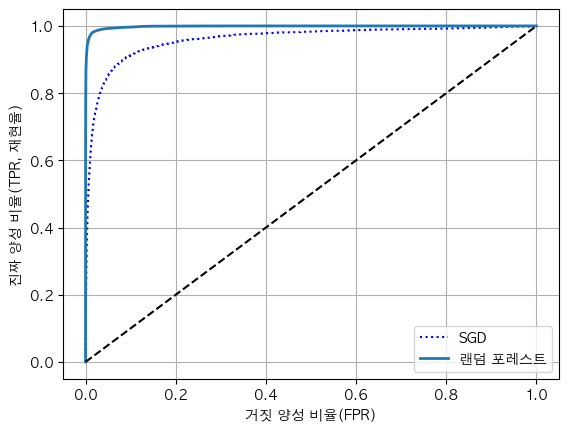

In [17]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, '랜덤 포레스트')
plt.legend(loc='lower right')

### 결과
- 랜덤포레스트의 ROC곡선이 왼쪽 위 모서리에 훨씬 가깝다 = 거짓 양성 비율을 낮게 유지하면서 재현율을 훨씬 더 높게 올릴 수 있다